In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019/valid.csv
/kaggle/input/aptos2019/test.csv
/kaggle/input/aptos2019/train_1.csv
/kaggle/input/aptos2019/val_images/val_images/17f6c7072f61.png
/kaggle/input/aptos2019/val_images/val_images/0243404e8a00.png
/kaggle/input/aptos2019/val_images/val_images/0083ee8054ee.png
/kaggle/input/aptos2019/val_images/val_images/0ac436400db4.png
/kaggle/input/aptos2019/val_images/val_images/0d0a21fd354f.png
/kaggle/input/aptos2019/val_images/val_images/02da652c74b8.png
/kaggle/input/aptos2019/val_images/val_images/15e96e848b46.png
/kaggle/input/aptos2019/val_images/val_images/059bc89df7f4.png
/kaggle/input/aptos2019/val_images/val_images/04d029cfb612.png
/kaggle/input/aptos2019/val_images/val_images/08752092140d.png
/kaggle/input/aptos2019/val_images/val_images/0ef4c61dc056.png
/kaggle/input/aptos2019/val_images/val_images/1a7e3356b39c.png
/kaggle/input/aptos2019/val_images/val_images/06be1092a062.png
/kaggle/input/aptos2019/val_images/val_images/03a7f4a5786f.png
/kaggle/input/a

In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import timm
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

from scipy.optimize import minimize


# **Efiicent net b3 no segmentation**

In [4]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class CFG:
    # Data paths
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")

    # Model & Training parameters
    MODEL_NAME = 'efficientnet_b3' # Upgraded model
    IMG_SIZE = 384                 # Increased image size
    BATCH_SIZE = 8                 # Reduced batch size to fit larger images in memory
    NUM_WORKERS = 2
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Stage 1: Weighted Focal Loss Training
    S1_EPOCHS = 15
    S1_LR = 1e-4
    S1_USE_MIXUP = True
    
    # Stage 2: Hybrid Loss Fine-tuning
    S2_EPOCHS = 15
    S2_LR = 3e-5 
    S2_USE_MIXUP = False
    
    # General
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05

# Seed everything for reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # Can be True for performance if input sizes are fixed

seed_everything(CFG.SEED)


# =============================================================================
# PREPROCESSING & AUGMENTATIONS
# =============================================================================
def preprocess_ben_graham(image_np, output_size):
    # This function now expects a numpy array from Albumentations
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: # Heuristic for nearly all-black images
             return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)

        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception:
        pass

    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    return cv2.merge((b, g, r))

# Advanced Augmentations using Albumentations
def get_transforms(img_size):
    # Pre-normalization transforms (applied to raw image)
    pre_transforms = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    ])
    # Post-normalization transforms
    post_transforms = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    val_transforms = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    return pre_transforms, post_transforms, val_transforms


# =============================================================================
# DATASET
# =============================================================================
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, pre_transform=None, post_transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.pre_transform = pre_transform
        self.post_transform = post_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        # Load with OpenCV for Albumentations
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.pre_transform:
            augmented = self.pre_transform(image=img)
            img = augmented['image']
        
        # Apply normalization and ToTensor after other augs
        if self.post_transform:
            tensor_aug = self.post_transform(image=img)
            img = tensor_aug['image']

        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# =============================================================================
# LOSSES & MODEL
# =============================================================================
class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, outputs, targets):
        # Create ordinal targets with label smoothing
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0:
                ordinal_targets[i, :t] = 1.0
        
        # Apply label smoothing
        if self.label_smoothing > 0.0:
            ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing

        bce = self.bce(outputs, ordinal_targets)
        
        # Apply class weights to the loss for each sample
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights

        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

# SmoothKappaLoss and Model remain the same as before...
class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)

    def forward(self, outputs, targets):
        device = outputs.device
        B = outputs.size(0)
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1):
            class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        
        hist_true = one_hot.sum(dim=0)
        hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)

        W = self.W.to(device)
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa
        
class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name='efficientnet_b3', num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)


# Utilities and Training loops remain the same...

def ordinal_to_class(outputs):
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    acc = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    return acc, qwk

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train()
    running_loss = 0.0
    all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        all_out.append(outputs.detach())
        all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================
def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME}, Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV)
    val_df = pd.read_csv(CFG.VAL_CSV)

    pre_tf, post_tf, val_tf = get_transforms(CFG.IMG_SIZE)

    train_ds = DiabeticRetinopathyDataset(train_df, CFG.TRAIN_DIR, pre_transform=pre_tf, post_transform=post_tf)
    val_ds   = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, pre_transform=val_tf) # val_tf does all steps

    # Sampler for imbalance
    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

    # Model and losses
    model = EfficientNetOrdinal(CFG.MODEL_NAME, num_classes=5).to(CFG.DEVICE)
    
    # Class weights for the loss function
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    
    # LOSSES
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    # HYBRID LOSS for STAGE 2
    def hybrid_loss(outputs, targets):
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1: WEIGHTED FOCAL LOSS ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1: WEIGHTED FOCAL LOSS\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()

        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")

        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), "best_model_stage1.pth")
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 1."); break
    
    # --- STAGE 2: HYBRID LOSS FINE-TUNING ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2: HYBRID LOSS FINE-TUNING\n" + "="*50)
    model.load_state_dict(torch.load("best_model_stage1.pth"))
    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")

        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), "best_model_final.pth")
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 2."); break

    print(f"\nTraining Finished!\nBest Stage 1 QWK: {best_val_qwk:.4f}\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()

Device: cuda, Model: efficientnet_b3, Image Size: 384


/tmp/ipykernel_36/372004193.py:98: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_36/372004193.py:111: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


     STARTING STAGE 1: WEIGHTED FOCAL LOSS

Epoch 1/15


/tmp/ipykernel_36/372004193.py:339: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.4436, Acc: 0.2502, QWK: 0.1740
Valid -> Loss: 0.1938, Acc: 0.1421, QWK: 0.4300
Val QWK improved from -1.0000 to 0.4300. Saving model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3473, Acc: 0.3348, QWK: 0.3373
Valid -> Loss: 0.1600, Acc: 0.1858, QWK: 0.6596
Val QWK improved from 0.4300 to 0.6596. Saving model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2963, Acc: 0.3549, QWK: 0.3545
Valid -> Loss: 0.1527, Acc: 0.2295, QWK: 0.6351

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2731, Acc: 0.3874, QWK: 0.4074
Valid -> Loss: 0.1451, Acc: 0.2596, QWK: 0.6105

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2554, Acc: 0.4055, QWK: 0.4045
Valid -> Loss: 0.1502, Acc: 0.2213, QWK: 0.6239

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2434, Acc: 0.4041, QWK: 0.4256
Valid -> Loss: 0.1640, Acc: 0.2186, QWK: 0.6738
Val QWK improved from 0.6596 to 0.6738. Saving model...

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2114, Acc: 0.4150, QWK: 0.4456
Valid -> Loss: 0.1519, Acc: 0.2732, QWK: 0.6601

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2071, Acc: 0.4334, QWK: 0.4355
Valid -> Loss: 0.1283, Acc: 0.3142, QWK: 0.7056
Val QWK improved from 0.6738 to 0.7056. Saving model...

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1974, Acc: 0.4051, QWK: 0.4239
Valid -> Loss: 0.1412, Acc: 0.3852, QWK: 0.7201
Val QWK improved from 0.7056 to 0.7201. Saving model...

Epoch 10/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1975, Acc: 0.4403, QWK: 0.4712
Valid -> Loss: 0.1412, Acc: 0.3497, QWK: 0.7033

Epoch 11/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2001, Acc: 0.4437, QWK: 0.4532
Valid -> Loss: 0.1494, Acc: 0.4016, QWK: 0.6996

Epoch 12/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2052, Acc: 0.4420, QWK: 0.4821
Valid -> Loss: 0.1436, Acc: 0.4317, QWK: 0.7299
Val QWK improved from 0.7201 to 0.7299. Saving model...

Epoch 13/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1926, Acc: 0.4608, QWK: 0.5128
Valid -> Loss: 0.1481, Acc: 0.4781, QWK: 0.7306
Val QWK improved from 0.7299 to 0.7306. Saving model...

Epoch 14/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1877, Acc: 0.4560, QWK: 0.4737
Valid -> Loss: 0.1418, Acc: 0.4481, QWK: 0.7204

Epoch 15/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1928, Acc: 0.4451, QWK: 0.4329
Valid -> Loss: 0.1433, Acc: 0.4536, QWK: 0.7184

     STARTING STAGE 2: HYBRID LOSS FINE-TUNING

Epoch 1/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1727, Acc: 0.6932, QWK: 0.9008
Valid -> Loss: 0.2252, Acc: 0.7104, QWK: 0.8815
Val QWK improved from 0.7306 to 0.8815. Saving final model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1038, Acc: 0.8461, QWK: 0.9556
Valid -> Loss: 0.1884, Acc: 0.7486, QWK: 0.8969
Val QWK improved from 0.8815 to 0.8969. Saving final model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0969, Acc: 0.8543, QWK: 0.9565
Valid -> Loss: 0.1668, Acc: 0.7732, QWK: 0.9080
Val QWK improved from 0.8969 to 0.9080. Saving final model...

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0820, Acc: 0.8874, QWK: 0.9663
Valid -> Loss: 0.1649, Acc: 0.8005, QWK: 0.9140
Val QWK improved from 0.9080 to 0.9140. Saving final model...

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0775, Acc: 0.8925, QWK: 0.9684
Valid -> Loss: 0.1721, Acc: 0.7787, QWK: 0.9055

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0708, Acc: 0.9102, QWK: 0.9744
Valid -> Loss: 0.1795, Acc: 0.8033, QWK: 0.9013

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0694, Acc: 0.9147, QWK: 0.9757
Valid -> Loss: 0.1761, Acc: 0.7978, QWK: 0.9015

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0658, Acc: 0.9229, QWK: 0.9756
Valid -> Loss: 0.1701, Acc: 0.7978, QWK: 0.9071

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0640, Acc: 0.9270, QWK: 0.9780
Valid -> Loss: 0.1712, Acc: 0.8005, QWK: 0.9085
Early stopping in Stage 2.

Training Finished!
Best Stage 1 QWK: 0.7306
Final Best QWK: 0.9140


Model loaded successfully from best_model_final.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


/tmp/ipykernel_36/3685558434.py:112: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),


Getting Validation Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.5494 0.2889 0.4056 0.7387]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


                 FINAL RESULTS COMPARISON (EfficientNet-B3)

Original Score (Threshold = 0.5):
  QWK: 0.9128
  Accuracy: 81.69%

Polished Score (Optimized Thresholds):
  QWK: 0.9208
  Accuracy: 83.06%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98       199
     Class 1       0.52      0.57      0.54        30
     Class 2       0.73      0.75      0.74        87
     Class 3       0.33      0.53      0.41        17
     Class 4       0.90      0.55      0.68        33

    accuracy                           0.83       366
   macro avg       0.69      0.67      0.67       366
weighted avg       0.85      0.83      0.84       366


--- Polished Confusion Matrix ---


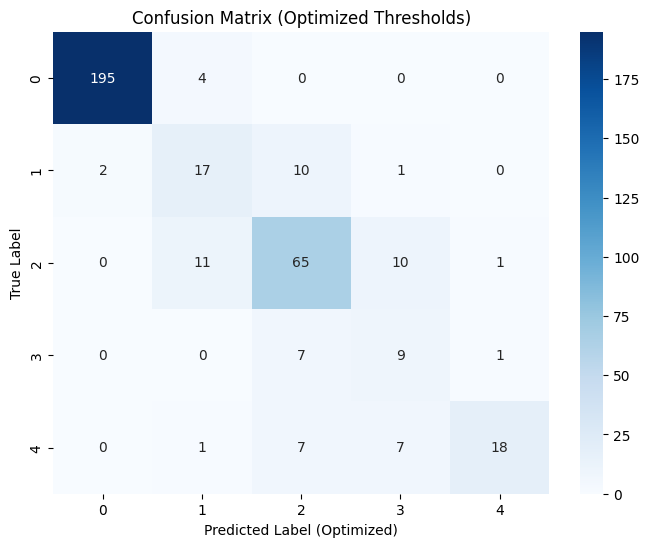

In [35]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize

# =============================================================================
# CONFIGURATION FOR EFFICIENTNET-B3
# =============================================================================
class CFG:
    # --- MODEL CONFIG ---
    MODEL_NAME = 'efficientnet_b3'
    IMG_SIZE = 384
    
    # --- PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    # We need paths for both validation (to find thresholds) and test (for final score)
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # Path to your saved EfficientNet-B3 model
    MODEL_PATH = "best_model_final.pth"
    
    # --- INFERENCE CONFIG ---
    BATCH_SIZE = 8 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING
# =============================================================================
class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))
    def forward(self, x): return self.classifier(self.backbone(x))

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df, self.img_dir, self.transform = df.reset_index(drop=True), img_dir, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform: img = self.transform(image=img)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach()
    targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5])
    bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = EfficientNetOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            val_outputs_list.append(outputs.cpu())
            val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list)
    val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = DiabeticRetinopathyDataset(test_df, CFG.TEST_DIR, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            test_outputs_list.append(outputs.cpu())
            test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("                 FINAL RESULTS COMPARISON (EfficientNet-B3)")
    print("="*50)

    # Score with OLD simple 0.5 threshold
    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):")
    print(f"  QWK: {qwk_old:.4f}")
    print(f"  Accuracy: {acc_old*100:.2f}%")

    # Score with NEW optimized thresholds
    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):")
    print(f"  QWK: {qwk_new:.4f}")
    print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    # --- NEW: DETAILED REPORT FOR POLISHED SCORE ---
    print("\n--- Polished Classification Report ---")
    print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()


# Efficent net B4

Model loaded successfully from /kaggle/input/efficent-net-b4-best-model-no-segmentation/efficent net b4/best_model_effnet_b4_final_stage2.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


/tmp/ipykernel_36/455951089.py:112: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),


Getting Validation Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.2804 0.1664 0.589  0.7197]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


                 FINAL RESULTS COMPARISON (EfficientNet-B4)

Original Score (Threshold = 0.5):
  QWK: 0.9073
  Accuracy: 78.96%

Polished Score (Optimized Thresholds):
  QWK: 0.9125
  Accuracy: 80.60%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       199
     Class 1       0.58      0.50      0.54        30
     Class 2       0.69      0.78      0.74        87
     Class 3       0.24      0.53      0.33        17
     Class 4       0.91      0.30      0.45        33

    accuracy                           0.81       366
   macro avg       0.68      0.62      0.61       366
weighted avg       0.85      0.81      0.81       366


--- Polished Confusion Matrix ---


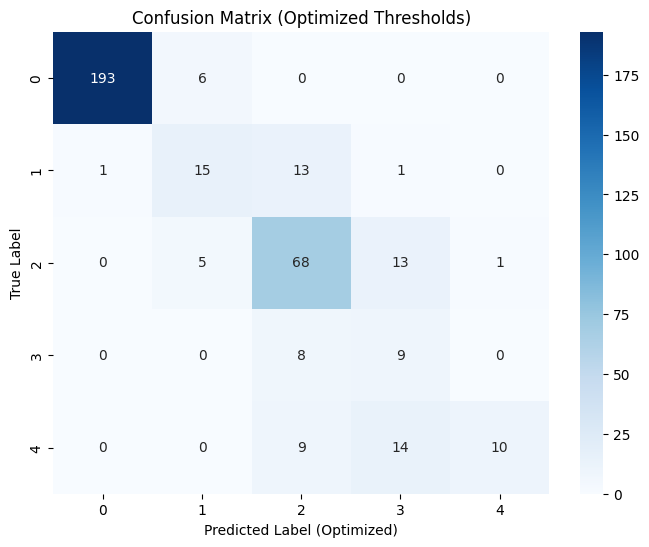

In [18]:
# =============================================================================
# CONFIGURATION FOR EFFICIENTNET-B4
# =============================================================================
class CFG:
    # --- MODEL CONFIG ---
    MODEL_NAME = 'efficientnet_b4'
    IMG_SIZE = 384
    
    # --- PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    # We need paths for both validation (to find thresholds) and test (for final score)
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # Path to your saved EfficientNet-B4 model
    MODEL_PATH = "/kaggle/input/efficent-net-b4-best-model-no-segmentation/efficent net b4/best_model_effnet_b4_final_stage2.pth"
    
    # --- INFERENCE CONFIG ---
    BATCH_SIZE = 8 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING
# =============================================================================
class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))
    def forward(self, x): return self.classifier(self.backbone(x))

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df, self.img_dir, self.transform = df.reset_index(drop=True), img_dir, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform: img = self.transform(image=img)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach()
    targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5])
    bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = EfficientNetOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            val_outputs_list.append(outputs.cpu())
            val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list)
    val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = DiabeticRetinopathyDataset(test_df, CFG.TEST_DIR, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            test_outputs_list.append(outputs.cpu())
            test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("                 FINAL RESULTS COMPARISON (EfficientNet-B4)")
    print("="*50)

    # Score with OLD simple 0.5 threshold
    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):")
    print(f"  QWK: {qwk_old:.4f}")
    print(f"  Accuracy: {acc_old*100:.2f}%")

    # Score with NEW optimized thresholds
    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):")
    print(f"  QWK: {qwk_new:.4f}")
    print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    # --- NEW: DETAILED REPORT FOR POLISHED SCORE ---
    print("\n--- Polished Classification Report ---")
    print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()

# Swinv2

Model loaded successfully from /kaggle/input/swin-no-segmentaion/SWIN ALONE 1ST TIME/best_model_swin_final.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


/tmp/ipykernel_36/3544853506.py:118: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),


Getting Validation Outputs:   0%|          | 0/23 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.5947 0.1133 0.7584 0.5467]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/23 [00:00<?, ?it/s]


              FINAL RESULTS COMPARISON (Swin Transformer)

Original Score (Threshold = 0.5):
  QWK: 0.9045
  Accuracy: 72.95%

Polished Score (Optimized Thresholds):
  QWK: 0.9143
  Accuracy: 77.32%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       199
     Class 1       0.45      0.63      0.53        30
     Class 2       0.75      0.52      0.61        87
     Class 3       0.23      0.71      0.35        17
     Class 4       0.78      0.42      0.55        33

    accuracy                           0.77       366
   macro avg       0.64      0.65      0.60       366
weighted avg       0.84      0.77      0.79       366


--- Polished Confusion Matrix ---


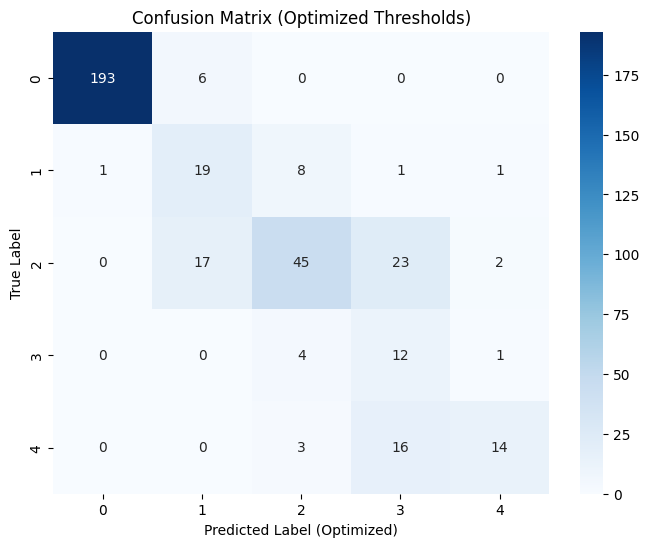

In [20]:
# =============================================================================
# CONFIGURATION FOR SWIN TRANSFORMER
# =============================================================================
class CFG:
    # --- MODEL CONFIG ---
    MODEL_NAME = 'swinv2_tiny_window8_256'
    IMG_SIZE = 256
    
    # --- PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    # We need paths for both validation (to find thresholds) and test (for final score)
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # Path to your saved Swin Transformer model
    MODEL_PATH = "/kaggle/input/swin-no-segmentaion/SWIN ALONE 1ST TIME/best_model_swin_final.pth"
    
    # --- INFERENCE CONFIG ---
    BATCH_SIZE = 16 # Can be larger for the smaller image size
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING
# =============================================================================
class SwinOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x): 
        return self.classifier(self.backbone(x))

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df, self.img_dir, self.transform = df.reset_index(drop=True), img_dir, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform: img = self.transform(image=img)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach()
    targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5])
    bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = SwinOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            val_outputs_list.append(outputs.cpu())
            val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list)
    val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = DiabeticRetinopathyDataset(test_df, CFG.TEST_DIR, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            test_outputs_list.append(outputs.cpu())
            test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("              FINAL RESULTS COMPARISON (Swin Transformer)")
    print("="*50)

    # Score with OLD simple 0.5 threshold
    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):")
    print(f"  QWK: {qwk_old:.4f}")
    print(f"  Accuracy: {acc_old*100:.2f}%")

    # Score with NEW optimized thresholds
    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):")
    print(f"  QWK: {qwk_new:.4f}")
    print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    # --- NEW: DETAILED REPORT FOR POLISHED SCORE ---
    print("\n--- Polished Classification Report ---")
    print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()


# Ensenmble Test

All expert models loaded successfully.

--- Step 1: Generating features from Validation Set ---


/tmp/ipykernel_36/1148009120.py:95: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.MODELS[key]["img_size"])),


Creating Validation Features:   0%|          | 0/46 [00:00<?, ?it/s]

Validation feature matrix created with shape: (366, 8)

--- Step 2: Training the Stacking Meta-Model ---
Meta-model (RandomForest) trained successfully.

--- Step 3: Evaluating on Test Set with Stacking Ensemble ---


Creating Test Features:   0%|          | 0/46 [00:00<?, ?it/s]


   FINAL STACKING ENSEMBLE RESULTS (B3 + Swin)
Final Quadratic Weighted Kappa: 0.8863
Final Accuracy: 0.8197 (81.97%)

--- Final Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98       199
     Class 1       0.48      0.40      0.44        30
     Class 2       0.64      0.89      0.74        87
     Class 3       0.60      0.18      0.27        17
     Class 4       0.78      0.42      0.55        33

    accuracy                           0.82       366
   macro avg       0.70      0.57      0.60       366
weighted avg       0.82      0.82      0.81       366


--- Final Confusion Matrix ---


AttributeError: QuadMesh.set() got an unexpected keyword argument 'ylabels'

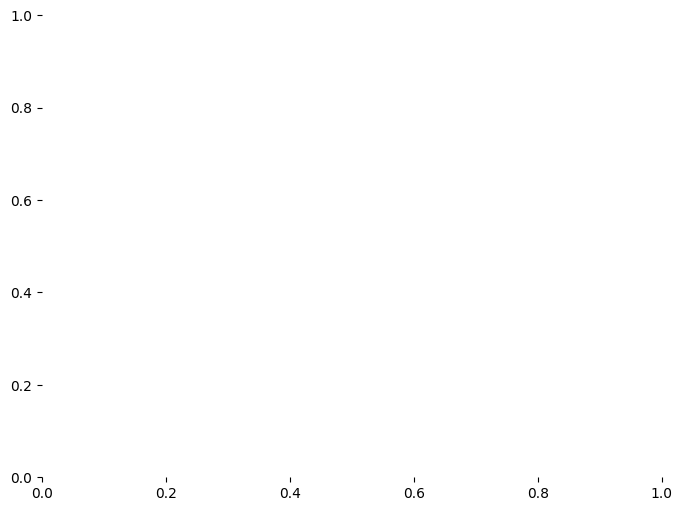

In [40]:
# =-===========================================================================
# FINAL ENSEMBLE CONFIGURATION
# =============================================================================
class CFG:
    BASE_PATH = "/kaggle/input/aptos2019"
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    BATCH_SIZE = 8
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    SEED = 42

    # --- Paths and configs for the two models to be ensembled ---
    MODELS = {
        "effnet_b3": {
            "model_name": 'efficientnet_b3', "img_size": 384,
            "path": "/kaggle/working/best_model_final.pth" 
        },
        "swin": {
            "model_name": 'swinv2_tiny_window8_256', "img_size": 256,
            "path": "/kaggle/input/swin-no-segmentaion/SWIN ALONE 1ST TIME/best_model_swin_final.pth"
        }
    }

# --- Model Architectures ---
class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__(); self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg'); feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 4))
    def forward(self, x): return self.classifier(self.backbone(x))

class SwinOrdinal(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__(); self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg'); feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 4))
    def forward(self, x): return self.classifier(self.backbone(x))

# --- Dataset and Preprocessing ---
def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea); x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class UltimateEnsembleDataset(Dataset):
    def __init__(self, df, img_dir, transforms_dict):
        self.df, self.img_dir, self.transforms = df.reset_index(drop=True), img_dir, transforms_dict
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images = {key: self.transforms[key](image=img)['image'] for key in self.transforms}
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return images, label

# --- Main Evaluation Function ---
def run_stacking_ensemble():
    # --- Step 0: Load all deep learning models ---
    models = {
        "effnet_b3": EfficientNetOrdinal(CFG.MODELS["effnet_b3"]["model_name"]),
        "swin": SwinOrdinal(CFG.MODELS["swin"]["model_name"])
    }
    for key in models:
        models[key].load_state_dict(torch.load(CFG.MODELS[key]["path"], map_location=CFG.DEVICE))
        models[key].to(CFG.DEVICE).eval()
    print("All expert models loaded successfully.")

    transforms = {key: A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.MODELS[key]["img_size"])),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])
        for key in CFG.MODELS
    }

    # --- Step 1: Generate features for the meta-model from the VALIDATION set ---
    print("\n--- Step 1: Generating features from Validation Set ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = UltimateEnsembleDataset(val_df, CFG.VAL_DIR, transforms)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_probs_all_models = {key: [] for key in CFG.MODELS}
    val_labels_list = []
    
    with torch.no_grad():
        for images_dict, labels in tqdm(val_loader, desc="Creating Validation Features"):
            for key in models:
                images = images_dict[key].to(CFG.DEVICE)
                probs = torch.sigmoid(models[key](images)) # Using simple probabilities as features
                val_probs_all_models[key].append(probs.cpu())
            val_labels_list.append(labels)
    
    val_labels = torch.cat(val_labels_list).numpy()
    val_probs_tensors = [torch.cat(val_probs_all_models[key]) for key in CFG.MODELS]
    
    # Create the feature matrix for the meta-model
    X_val = np.concatenate([p.numpy() for p in val_probs_tensors], axis=1)
    y_val = val_labels
    print(f"Validation feature matrix created with shape: {X_val.shape}")

    # --- Step 2: Train the "Manager" Meta-Model ---
    print("\n--- Step 2: Training the Stacking Meta-Model ---")
    meta_model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=CFG.SEED, n_jobs=-1)
    meta_model.fit(X_val, y_val)
    print("Meta-model (RandomForest) trained successfully.")
    
    # --- Step 3: Generate features from the TEST set and predict with the Meta-Model ---
    print("\n--- Step 3: Evaluating on Test Set with Stacking Ensemble ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = UltimateEnsembleDataset(test_df, CFG.TEST_DIR, transforms)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_probs_all_models = {key: [] for key in CFG.MODELS}
    test_labels_list = []

    with torch.no_grad():
        for images_dict, labels in tqdm(test_loader, desc="Creating Test Features"):
            for key in models:
                images = images_dict[key].to(CFG.DEVICE)
                probs = torch.sigmoid(models[key](images))
                test_probs_all_models[key].append(probs.cpu())
            test_labels_list.append(labels)

    test_labels = torch.cat(test_labels_list).numpy()
    test_probs_tensors = [torch.cat(test_probs_all_models[key]) for key in CFG.MODELS]
    X_test = np.concatenate([p.numpy() for p in test_probs_tensors], axis=1)
    
    # Make final predictions using the trained manager model
    final_preds = meta_model.predict(X_test)
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("   FINAL STACKING ENSEMBLE RESULTS (B3 + Swin)")
    print("="*50)
    
    qwk = cohen_kappa_score(test_labels, final_preds, weights='quadratic')
    accuracy = accuracy_score(test_labels, final_preds)
    
    print(f"Final Quadratic Weighted Kappa: {qwk:.4f}")
    print(f"Final Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print("\n--- Final Classification Report ---")
    print(classification_report(test_labels, final_preds, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Final Confusion Matrix ---")
    cm = confusion_matrix(test_labels, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), ylabels=range(5))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Stacking Ensemble Confusion Matrix (B3 + Swin)")
    plt.show()

run_stacking_ensemble()



----------------------------------------

--------------------------------------------------------------------------------------

